# Visualising the X-ray observations of LoVoCCS clusters

In this notebook we generate visualisations of the archival observations of our LoVoCCS sample that we have identified using DAXA - specifically we generate individual ObsID-Instrument level observations, nothing is co-added in this notebook, and overlay a simple cross-hair to indicate the position of the cluster.

An example of a visualisation for each mission is displayed in the notebook, but otherwise all visualisations are saved to disk without being displayed to avoid making this notebook too large - that can cause Jupyter to misbehave and also stops the notebook being rendered on the GitHub website.

## Import Statements

In [1]:
from shutil import rmtree
import os
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.visualization import SqrtStretch, LogStretch
from astropy.io import fits
from tqdm import tqdm

# I am only importing XGA because it has some quite handy product classes that we can use for some
#  of the visualisations
import xga
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products import Image, ExpMap, RateMap

%matplotlib inline

## Reading in the sample

We need our sample information so that we can plot coordinates on images that we create, as well as possibly overlaying radius information:

In [2]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes
0,MCXCJ1558.3+2713,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L
1,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN
2,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L
3,MCXCJ1348.8+2635,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN
4,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr"
...,...,...,...,...,...,...,...,...,...,...,...,...
139,MCXCJ0448.2-2028,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr
140,MCXCJ2323.8+1648,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN
141,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X
142,MCXCJ1459.0-0843,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN


## Defining useful paths

Paths useful to the entire notebook are added here, and we also make sure that the source-name-level output directories for the cluster visualisations have been created:

In [3]:
# This is where we store the output visualisations - where n is the name of the source, and {m} is the name
#  of the mission for which a visualisation is being made. The 'indiv' suffix is because these are individual 
#  ObsID-Instrument visualisations, not co-added
out_path = "../../outputs/cluster_visualisations/{n}/{m}_indiv/"

for lov_id in samp['LoVoCCSID'].values:
    lov_name = "LoVoCCS-{}".format(lov_id)
    
    if not os.path.exists('../../outputs/cluster_visualisations/{n}'.format(n=lov_name)):
        os.makedirs('../../outputs/cluster_visualisations/{n}'.format(n=lov_name))

## Making cluster visualisations

In this notebook we will limit ourselves to making visualisations of individual instruments of the different missions, rather than creating co-added images (even for instruments in the same mission, like the EPIC PN, MOS1, and MOS2 of XMM).

Here we will cycle through the available data, creating a visualisation for every valid observation-cluster combination (i.e. the cluster MCXC coordinate falls on the observation). Where they are immediately available we will use exposure maps to create visualisations with ratemaps, but where they are not we will (for now) just create photon-count images.

**It is important to note that these visualisations will not necessarily be of comparable scale - specifically any ROSAT PSPC and eROSITA images will cover much more sky than other visualisations, this is because we have not yet zoomed in on a physically defined region.**

### XMM-Newton

As we processed raw XMM data with DAXA, we have to look to the DAXA archive directories to find the images and exposure maps required for this process. As exposure maps are available we will be creating visualisations of count-rate, rather than just counts. The visualisations will be in the 0.5-2.0keV band, where the majority of the cluster signal is present.

First of all we define some paths:

In [4]:
xmm_path = "../../data/archives/LoVoCCS/processed_data/xmm_pointed/"
xmm_im_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVimg.fits"
xmm_ex_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVexpmap.fits"

xmm_obs_ids = [fp for fp in os.listdir(xmm_path) if len(fp) == 10]

We cycle through all the observations that were successfully processed for XMM, and make ratemaps visualisations of all available EPIC instruments for each. Only one ratemap visualisation is displayed in the notebook, to ensure that it does not become too large:

Generating XMM visualisations:   0%|          | 0/344 [00:00<?, ?it/s]

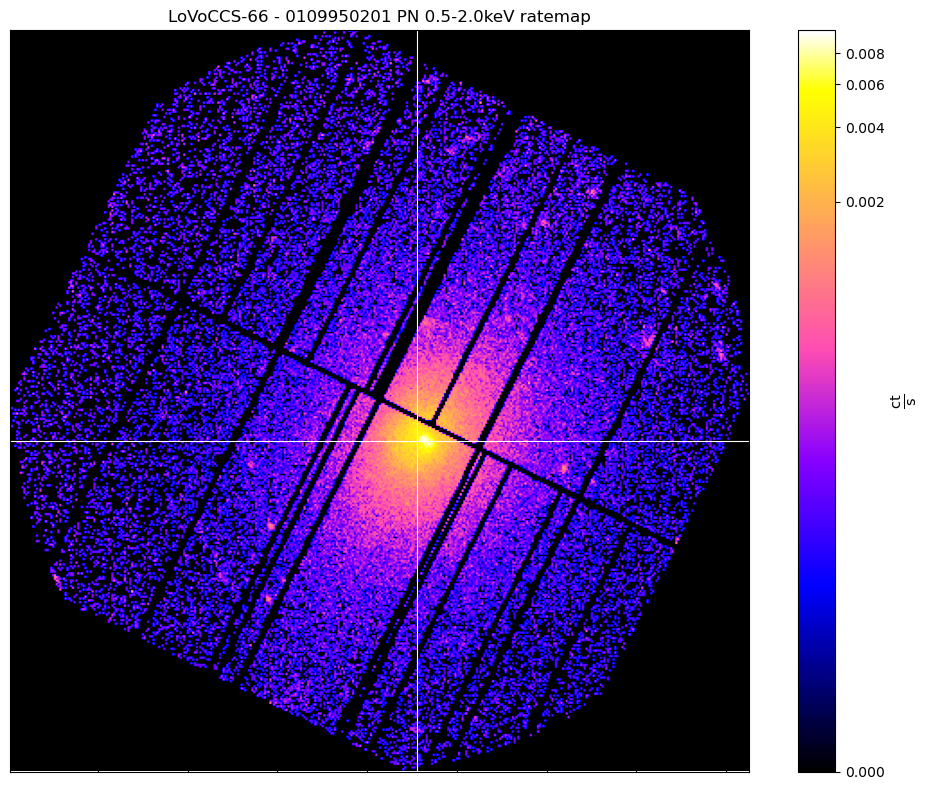

Generating XMM visualisations: 100%|██████████| 344/344 [07:19<00:00,  1.28s/it]


In [5]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm(desc='Generating XMM visualisations', total=len(xmm_obs_ids)) as onwards:
    for oi in xmm_obs_ids:
        for inst in ['pn', 'mos1', 'mos2']:
            cur_im = Image(xmm_im_path.format(oi=oi, i=inst), oi, inst, '', '', '', Quantity(0.5, 'keV'), 
                           Quantity(2.0, 'keV'))
            cur_ex = ExpMap(xmm_ex_path.format(oi=oi, i=inst), oi, inst, '', '', '', Quantity(0.5, 'keV'), 
                           Quantity(2.0, 'keV'))
            # If an image is not usable it is probably because that instrument doesn't have an image, and this is 
            #  just a brute force way of determing that rather than checking before I define
            if cur_im.usable:
                cur_rt = RateMap(cur_im, cur_ex)

                # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
                #  which observation was for which input position/object. Once I have this will be removed
                for row_ind, row in samp.iterrows():
                    cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                    cur_rt.src_name = cur_name
                    
                    cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                    cur_out_path = out_path.format(n=cur_name, m='xmm')

                    try:
                        # We try this first because it will throw a ValueError that we can catch if the coordinate
                        #  is completely outside the valid region for this observation, without leaving an ugly
                        #  empty axis as would happen with the view method in that situation
                        cur_rt.coord_conv(cur_coord, 'pix')
                        if show_vis:
                            cur_rt.view(cur_coord, zoom_in=True)
                            # Now no-more visualisations will be shown in the notebook, only saved to disk
                            show_vis = False

                        # Make sure the output directory where we'll send the visualisation we're about to store
                        #  actually exists
                        if not os.path.exists(cur_out_path):
                            os.makedirs(cur_out_path)

                        # Then create a visualisation without displaying it, just saving it to disk
                        cur_rt.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                         cur_coord, zoom_in=True)

                    # If this is triggered it's because the current object isn't anywhere near this particular
                    #  observation - we don't have to worry though, it's just a consequence of the brute force
                    #  way that I'm currently doing this
                    except ValueError:
                        pass
        onwards.update(1)

### Chandra

Now we're on to missions that we have not processed data for ourselves; however we did tell DAXA to acquire the standard distribution of Chandra data, which includes full field-of-view FITS images, which we can use here. The standard data do not include pre-generated exposure maps, so we will be creating photon-count images, rather than count rate maps. The energy range also differs from XMM, as the standard images are made in the 0.5-7.0keV range.

Useful paths are defined, though we are not as specific about the structure of the image file name as we were with XMM, as the file name can change depending on the processing version and the instrument:

In [6]:
ch_path = "../../data/chandra_raw/"
ch_dat_path = ch_path + "{oi}/primary/"
ch_im_path = ch_path + "{oi}/primary/{im_f}"

ch_obs_ids = [fp for fp in os.listdir(ch_path)]

We cycle through all the observations that we acquired for Chandra, and make photon-count image visualisations for each. Only one image visualisation is displayed in the notebook, to ensure that it does not become too large:

Generating Chandra visualisations:   0%|          | 0/575 [00:00<?, ?it/s]

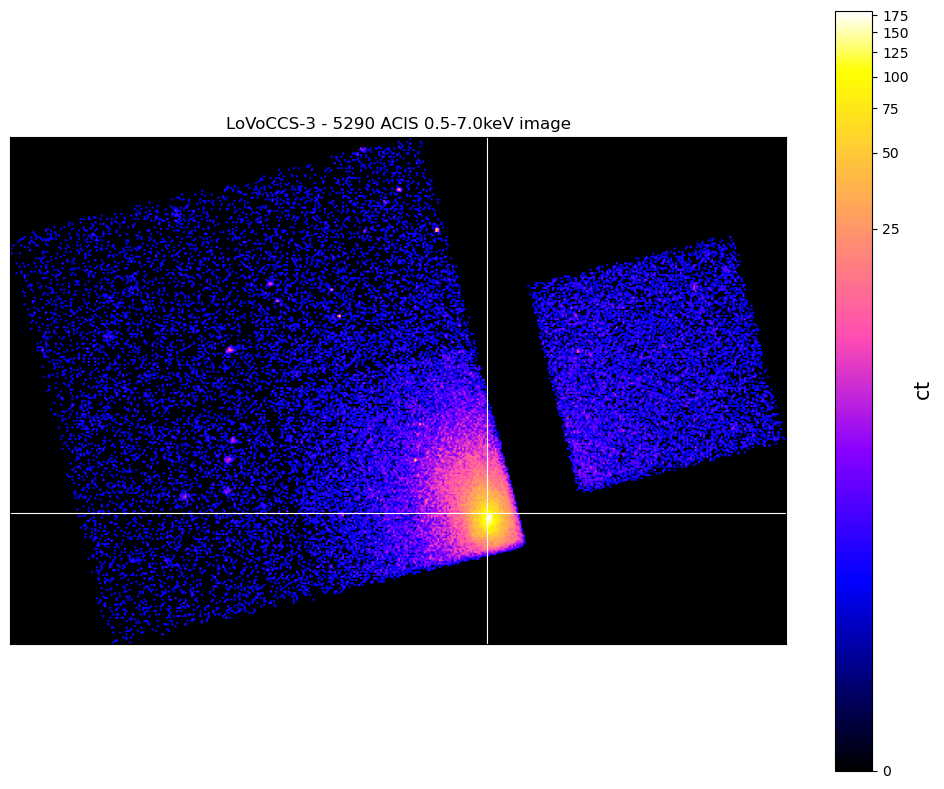

Generating Chandra visualisations: 100%|██████████| 575/575 [03:34<00:00,  2.67it/s]


In [7]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm(desc='Generating Chandra visualisations', total=len(ch_obs_ids)) as onwards:
    for oi in ch_obs_ids:
        cur_im_path = ch_im_path.format(oi=oi, im_f=[f for f in os.listdir(ch_dat_path.format(oi=oi)) 
                                                     if 'full_img2' in f][0])
        inst = 'ACIS' if 'acis' in cur_im_path else 'HRC'
        
        cur_im = Image(cur_im_path, oi, inst, '', '', '', Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        # If an image is not usable it is probably because that instrument doesn't have an image, and this is 
        #  just a brute force way of determing that rather than checking before I define
        if cur_im.usable:
            # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
            #  which observation was for which input position/object. Once I have this will be removed
            for row_ind, row in samp.iterrows():
                cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                cur_im.src_name = cur_name

                cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                cur_out_path = out_path.format(n=cur_name, m='chandra')

                try:
                    # We try this first because it will throw a ValueError that we can catch if the coordinate
                    #  is completely outside the valid region for this observation, without leaving an ugly
                    #  empty axis as would happen with the view method in that situation
                    cur_im.coord_conv(cur_coord, 'pix')
                    if show_vis:
                        cur_im.view(cur_coord, zoom_in=True)
                        # Now no-more visualisations will be shown in the notebook, only saved to disk
                        show_vis = False

                    # Make sure the output directory where we'll send the visualisation we're about to store
                    #  actually exists
                    if not os.path.exists(cur_out_path):
                        os.makedirs(cur_out_path)

                    # Then create a visualisation without displaying it, just saving it to disk
                    cur_im.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                     cur_coord, zoom_in=True)

                # If this is triggered it's because the current object isn't anywhere near this particular
                #  observation - we don't have to worry though, it's just a consequence of the brute force
                #  way that I'm currently doing this
                except ValueError:
                    pass
        onwards.update(1)

### ROSAT All-Sky

We acquired pre-processed images and exposure maps for the ROSAT All-Sky 'observations' relevant to our LoVoCCS sample, so can create count-rate map visualisations rather than photon counting images. The energy range is different again, but we choose the one that the MCXC catalogue makes use of, and is most similar to the XMM range we chose, 0.4-2.4keV.

Again we define some paths - note that the file paths have two different versions of ObsID because the ObsIDs actually _in_ the file names are lowercase, and the path ObsIDs are uppercase:

In [8]:
rass_path = "../../data/rosat_all_sky_raw/"
rass_im_path = rass_path + "{oi}/{oi_l}_im2.fits"
rass_ex_path = rass_path + "{oi}/{oi_l}_mex.fits"

rass_obs_ids = [fp for fp in os.listdir(rass_path)]

We cycle through all the RASS 'observations', making a count-rate map for each. The exposure maps are included in the data directories for RASS, and are particular important because the RASS exposure changes across the field in some quite odd ways:

Generating RASS visualisations:   0%|          | 0/144 [00:00<?, ?it/s]

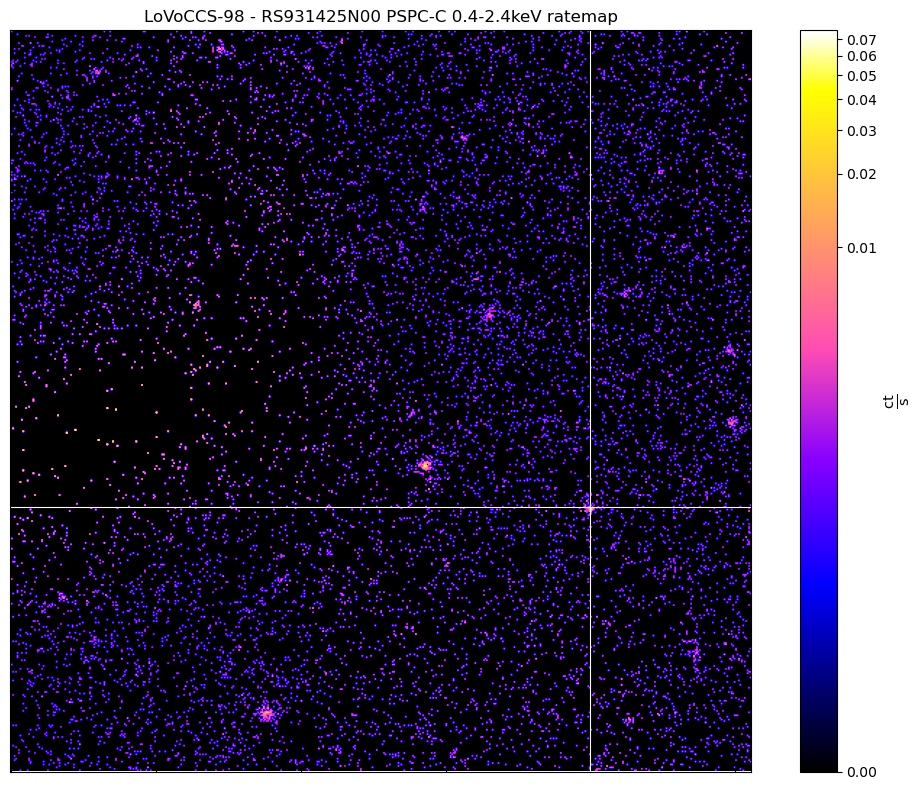

Generating RASS visualisations: 100%|██████████| 144/144 [01:18<00:00,  1.83it/s]


In [9]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm(desc='Generating RASS visualisations', total=len(rass_obs_ids)) as onwards:
    for oi in rass_obs_ids:

        cur_im = Image(rass_im_path.format(oi=oi, oi_l=oi.lower()), oi, 'PSPC-C', '', '', '', Quantity(0.4, 'keV'), 
                       Quantity(2.4, 'keV'))
        cur_ex = ExpMap(rass_ex_path.format(oi=oi, oi_l=oi.lower()), oi, 'PSPC-C', '', '', '', Quantity(0.4, 'keV'), 
                       Quantity(2.4, 'keV'))
        
        # If a image is not usable it is probably because that file does not exist, but that shouldn't occur
        #  here in theory - I still check for it though
        if cur_im.usable:
            cur_rt = RateMap(cur_im, cur_ex)

            # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
            #  which observation was for which input position/object. Once I have this will be removed
            for row_ind, row in samp.iterrows():
                cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                cur_rt.src_name = cur_name

                cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                cur_out_path = out_path.format(n=cur_name, m='rass')

                try:
                    # We try this first because it will throw a ValueError that we can catch if the coordinate
                    #  is completely outside the valid region for this observation, without leaving an ugly
                    #  empty axis as would happen with the view method in that situation
                    cur_rt.coord_conv(cur_coord, 'pix')
                    if show_vis:
                        cur_rt.view(cur_coord, zoom_in=True)
                        # Now no-more visualisations will be shown in the notebook, only saved to disk
                        show_vis = False

                    # Make sure the output directory where we'll send the visualisation we're about to store
                    #  actually exists
                    if not os.path.exists(cur_out_path):
                        os.makedirs(cur_out_path)

                    # Then create a visualisation without displaying it, just saving it to disk
                    cur_rt.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i='PSPCC'), 
                                     cur_coord, zoom_in=True)

                # If this is triggered it's because the current object isn't anywhere near this particular
                #  observation - we don't have to worry though, it's just a consequence of the brute force
                #  way that I'm currently doing this
                except ValueError:
                    pass
        onwards.update(1)

### ROSAT Pointed

We acquired pre-processed images and exposure maps (in the case of pointed PSPC) for the ROSAT pointed observations relevant to our LoVoCCS sample. The ROSAT HRI data archive does not contain exposure maps, so we can create count-rate map visualisations rather than photon counting images **for PSPC observations**. The PSPC count-rate maps will be in the 0.4-2.4keV energy range to match the MCXC range (and our RASS visualisations), but the HRI energy resolution is poor enough that we only have images in the 0.04-2.4keV band, which is what our visualisations of HRI will be in.

We do not currently make use of the background images that are provided in the ROSAT data archive.

Again we define some paths - note that the file paths have two different versions of ObsID because the ObsIDs actually _in_ the file names are lowercase, and the path ObsIDs are uppercase. We also have to specify the energy range in the file name now, as it will be different for PSPC (en=2) and HRI (en=1):

**I have found that sqrt scaling tends to make HRI observations of clusters more interpretable, so for now all HRI images will made with sqrt scaling - PSPC ratemaps will be made with standard log scaling.**

In [10]:
rosp_path = "../../data/rosat_pointed_raw/"
rosp_im_path = rosp_path + "{oi}/{oi_l}_im{en}.fits"
rosp_ex_path = rosp_path + "{oi}/{oi_l}_mex.fits"

rosp_obs_ids = [fp for fp in os.listdir(rosp_path)]

We cycle through all the pointed ROSAT observations, making a count-rate map for each PSPC pointing, and a photon-count image for each HRI pointing:

Generating pointed ROSAT visualisations:   0%|          | 0/218 [00:00<?, ?it/s]

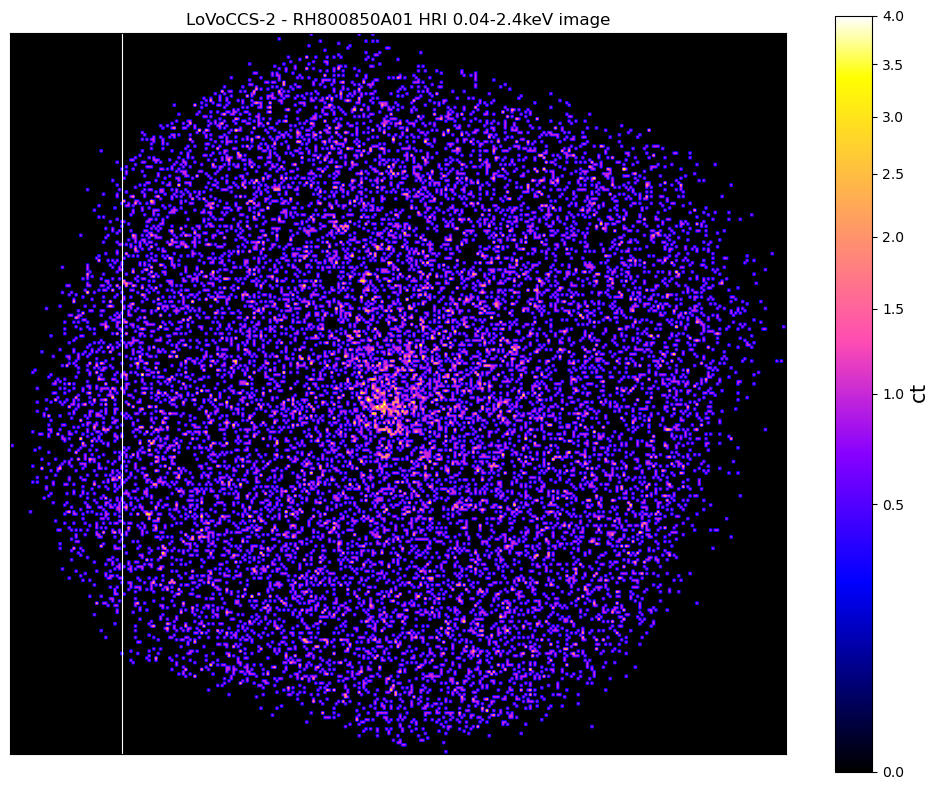

Generating pointed ROSAT visualisations: 100%|██████████| 218/218 [01:46<00:00,  2.04it/s]


In [11]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm(desc='Generating pointed ROSAT visualisations', total=len(rosp_obs_ids)) as onwards:
    for oi in rosp_obs_ids:
        
        cur_ex_path = [f for f in os.listdir(rosp_path + oi) if 'mex' in f]
        if len(cur_ex_path) != 0:
            cur_ex_path = cur_ex_path[0]
            # Not ALL of them are guaranteed to be PSPC-C I think, but most of them are
            inst = 'PSPC-B'
            en_lev = '2'
            lo_en = Quantity(0.4, 'keV')
            hi_en = Quantity(2.4, 'keV')
            stretch = LogStretch
        else:
            cur_ex_path = None
            inst = 'HRI'
            en_lev = '1'
            lo_en = Quantity(0.04, 'keV')
            hi_en = Quantity(2.4, 'keV')
            stretch = SqrtStretch
        
        cur_im = Image(rosp_im_path.format(oi=oi, oi_l=oi.lower(), en=en_lev), oi, inst, '', '', '', lo_en, hi_en)
        
        # No readily available HRI exposure maps to be downloaded by DAXA, thus we do without right now - they 
        #  can be generated though
        if inst != 'HRI':
            cur_ex = ExpMap(rosp_ex_path.format(oi=oi, oi_l=oi.lower(), en=en_lev), oi, inst, '', '', '', lo_en, 
                            hi_en)
        else:
            cur_ex = None
            
        # If a image is not usable it is probably because that file does not exist, but that shouldn't occur
        #  here in theory - I still check for it though
        if cur_im.usable:
            
            if cur_ex is not None:
                cur_prod = RateMap(cur_im, cur_ex)
            else:
                cur_prod = cur_im

            # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
            #  which observation was for which input position/object. Once I have this will be removed
            for row_ind, row in samp.iterrows():
                cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                cur_prod.src_name = cur_name

                cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                cur_out_path = out_path.format(n=cur_name, m='rosat_pointed')

                try:
                    # We try this first because it will throw a ValueError that we can catch if the coordinate
                    #  is completely outside the valid region for this observation, without leaving an ugly
                    #  empty axis as would happen with the view method in that situation
                    cur_prod.coord_conv(cur_coord, 'pix')
                    if show_vis:
                        cur_prod.view(cur_coord, zoom_in=True, stretch=stretch())
                        # Now no-more visualisations will be shown in the notebook, only saved to disk
                        show_vis = False

                    # Make sure the output directory where we'll send the visualisation we're about to store
                    #  actually exists
                    if not os.path.exists(cur_out_path):
                        os.makedirs(cur_out_path)

                    # Then create a visualisation without displaying it, just saving it to disk
                    cur_prod.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                     cur_coord, zoom_in=True, stretch=stretch())

                # If this is triggered it's because the current object isn't anywhere near this particular
                #  observation - we don't have to worry though, it's just a consequence of the brute force
                #  way that I'm currently doing this
                except ValueError:
                    pass
        else:
            print(cur_im.path)
            print(cur_im.not_usable_reasons)
            print('\n\n')
        onwards.update(1)

### NuSTAR

Again, DAXA cannot yet process NuSTAR data fully, so we made sure to acquire the pre-processed cleaned event lists and pre-generated images. Unfortunately there do not seem to be pre-generated exposure maps to hand, so these visualisations will be photon-count images again. 

We will generate an image for each of the two instruments on NuSTAR (the two focal plane modules have their own optics and so observe simultaneously).

NuSTAR has an extremely wide energy range, and I think that no energy filtering was applied when making the images - as such the events used are from NuSTAR's whole energy range, which is 3-78keV.

First off, we define some useful paths; the image path file extension is obviously that of the images we downloaded, but the first is really fits.gz, so will hopefully work:

In [12]:
nu_path = "../../data/nustar_pointed_raw/"
nu_im_path = nu_path + "{oi}/event_cl/nu{oi}{i}01_sk.img.gz"

nu_obs_ids = [fp for fp in os.listdir(nu_path)]

We cycle through all the observations that were successfully acquired for NuSTAR, and make image visualisations of all available instruments for each (i.e. FPMA and FPMB). Only one image visualisation is displayed in the notebook, to ensure that it does not become too large:

Generating NuSTAR visualisations:   4%|▍         | 1/26 [00:00<00:07,  3.31it/s]

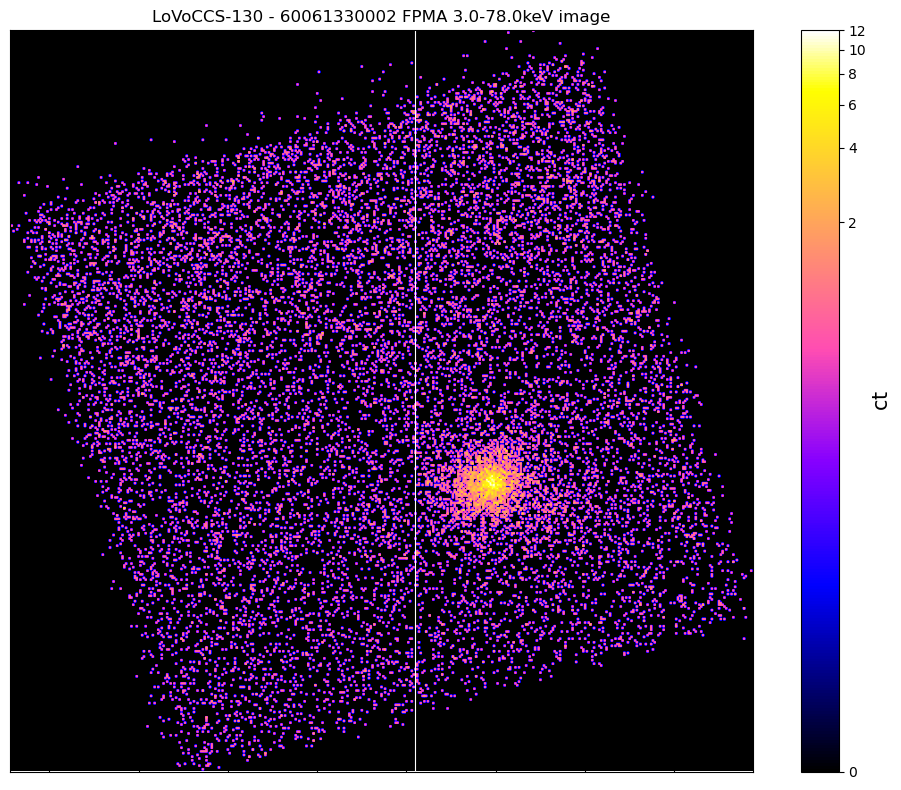

Generating NuSTAR visualisations: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


In [13]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm(desc='Generating NuSTAR visualisations', total=len(nu_obs_ids)) as onwards:
    for oi in nu_obs_ids:
        for inst in ['FPMA', 'FPMB']:
            cur_im = Image(nu_im_path.format(oi=oi, i=inst[-1]), oi, inst, '', '', '', Quantity(3.0, 'keV'), 
                           Quantity(78.0, 'keV'))

#             If an image is not usable it is probably because that instrument doesn't have an image, and this is 
#              just a brute force way of determing that rather than checking before I define
            if cur_im.usable:
                # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
                #  which observation was for which input position/object. Once I have this will be removed
                for row_ind, row in samp.iterrows():
                    cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                    cur_im.src_name = cur_name
                    
                    cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                    cur_out_path = out_path.format(n=cur_name, m='nustar')

                    try:
                        # We try this first because it will throw a ValueError that we can catch if the coordinate
                        #  is completely outside the valid region for this observation, without leaving an ugly
                        #  empty axis as would happen with the view method in that situation
                        cur_im.coord_conv(cur_coord, 'pix')
                        if show_vis:
                            cur_im.view(cur_coord, zoom_in=True)
                            # Now no-more visualisations will be shown in the notebook, only saved to disk
                            show_vis = False

                        # Make sure the output directory where we'll send the visualisation we're about to store
                        #  actually exists
                        if not os.path.exists(cur_out_path):
                            os.makedirs(cur_out_path)

                        # Then create a visualisation without displaying it, just saving it to disk
                        cur_im.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                         cur_coord, zoom_in=True)

                    # If this is triggered it's because the current object isn't anywhere near this particular
                    #  observation - we don't have to worry though, it's just a consequence of the brute force
                    #  way that I'm currently doing this
                    except ValueError:
                        pass
            else:
                print(cur_im.path)
                print(cur_im.not_usable_reasons)
                print('')
                    
        onwards.update(1)

### eROSITA Calibration and Performance Verification

This one is a bit different; we only get an events list when downloading eROSITA commissioning data, there is no option to download pre-generated images or exposure maps. I also don't want to require the eSASS software to run this notebook at the moment, so I am going to make my own image just in Python.

I just want a rough representation at the moment so it is possible that I won't include any GTIs or pattern selection. We start again by declaring paths, though it is faintly ridiculous when there can only ever be the two observations we already have. Also declare the bin size we're going for, which I've chosen to be the same as the standard XCS binning for XMM images:

<span style="color:red">I think I was taking the wrong approach here, should bin in detector coordinates and then use the event list WCS to correct for the non-linear relation between RA-Dec and X-Y; alternatively I might be entirely wrong</span>

In [14]:
bin_size = Quantity(4.35, 'arcsec')

er_path = "../../data/erosita_calpv_raw/"
er_ev_path = er_path + "{oi}/pm00_{oi}_020_EventList_c001.fits"

er_obs_ids = [fp for fp in os.listdir(er_path)]

In [15]:
Quantity(1.2, 'deg') / bin_size.to('deg')

<Quantity 993.10344828>

In [16]:
from astropy.visualization import ImageNormalize, MinMaxInterval

In [17]:
for oi in er_obs_ids:
    print(oi)
    cur_ev_path = er_ev_path.format(oi=oi)
    
    with fits.open(cur_ev_path) as fitto:
        evts = fitto['EVENTS']
        
        print(evts.data['DEC'].max())
        print(evts.data['DEC'].min())
        print(evts.data['DEC'].max()-evts.data['DEC'].min())
        
        print('')
        print(evts.data['RA'].max())
        print(evts.data['RA'].min())
        print(evts.data['RA'].max()-evts.data['RA'].min())
        
        
        ra_min = evts.data['RA'].min()-(10*bin_size.to('deg').value)
        ra_max = evts.data['RA'].max()+(10*bin_size.to('deg').value)
        dec_min = evts.data['DEC'].min()+(10*bin_size.to('deg').value)
        dec_max = evts.data['DEC'].max()-(10*bin_size.to('deg').value)
        
        ra_bins = int(round(abs((ra_min-ra_max)/bin_size.to('deg').value), 0))
        print(ra_bins)
        dec_bins = int(round(abs((dec_min-dec_max)/bin_size.to('deg').value), 0))
        print(dec_bins)
        
        ra_edges = np.arange(ra_min, ra_max, bin_size.to('deg').value)
        
        test_dec_cen = (dec_min+dec_max)/2
        dec_edges = np.arange(test_dec_cen - (ra_edges.shape[0]*bin_size.to('deg').value)/2, 
                              test_dec_cen + (ra_edges.shape[0]*bin_size.to('deg').value)/2, bin_size.to('deg').value)
        
        print(ra_edges.shape)
        print(dec_edges.shape)
        
#         print(dec_edges)
        
#         binned = np.histogram2d(evts.data['DEC'], evts.data['RA'], bins=[dec_bins, ra_bins])[0]
        binned = np.histogram2d(evts.data['DEC'], evts.data['RA'], bins=[dec_edges, ra_edges])[0]
        
        binned = np.fliplr(binned)
        
        norm = ImageNormalize(binned, MinMaxInterval(), stretch=LogStretch())
        
        print(binned.shape)
        
#         plt.figure(figsize=(14.93, 8.53))
        plt.imshow(binned, cmap='gnuplot2', origin='lower', norm=norm)
        plt.show()
        stop

700177
-53.10099448047642
-54.1556787480169
1.0546842675404804

56.594512861861084
54.815143968214024
1.7793688936470602
1493
853
(1493,)
(1493,)
(1492, 1492)


NameError: name 'plt' is not defined

In [ ]:
53.99617875 - 53.99497041

In [ ]:
bin_size.to('deg')